<a href="https://colab.research.google.com/github/valentina-s/Oceans19-data-science-tutorial/blob/master/notebooks/dask_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dask
====

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" 
     width="30%" 
     align=right
     alt="Dask logo">


Dask is a flexible parallel computing library for analytic computing. Dask provides dynamic parallel task scheduling and high-level big-data collections like `dask.array` and `dask.dataframe`. More on dask here: https://docs.dask.org/en/latest/

_Note: Pieces of this notebook comes from the following sources:_

- https://github.com/rabernat/research_computing
- https://github.com/dask/dask-examples

## Start a Dask distributed cluster and a Client for Dashboard

Starting the Dask Cluster/Client is generally optional.  
It provides a dashboard which is useful to gain insight on the computation.  
Using dask-kubernetes will also provide more computing power by scaling Dask on several nodes.

The link to the dashboard will become visible when you create the cluster or client below. As [dask-labextension](https://github.com/dask/dask-labextension) is integrated in the current environment, it can be sufficient for monitoring Dask tasks (see Task Stream and Progress windows on the right). Otherwise, we recommend having the dashboard open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

### If you have a Kubernetes cluster (which is the case when running on Pangeo binder)

Start the Dask cluster on Kubernetes, this will also activate the Dask windows on the right:

In [0]:
#from dask_kubernetes import KubeCluster
#cluster = KubeCluster()
#cluster.scale(4)
#cluster

Connect a client to it:

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 8787 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-10-30 06:27:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.231.170.111, 52.4.192.223, 52.7.202.148, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.231.170.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  41.6MB/s    in 0.3s    

2019-10-30 06:27:46 (41.6 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
http://89ad682d.ngrok.io


In [0]:
pip install bokeh

In [0]:
from dask.distributed import Client
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/316/19,Cluster Workers: 1 Cores: 2 Memory: 13.66 GB


In [0]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(processes=False)
client = Client(cluster)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/122/1,Cluster Workers: 1 Cores: 2 Memory: 13.66 GB


In [0]:
from dask.distributed import progress

# Dask Arrays

A dask array looks and feels a lot like a numpy array.
However, a dask array doesn't directly hold any data.
Instead, it symbolically represents the computations needed to generate the data.
Nothing is actually computed until the actual numerical values are needed.
This mode of operation is called "lazy"; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

If we want to create a numpy array of all ones, we do it like this:

In [0]:
import numpy as np
shape = (1000, 1000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

This array contains exactly 32 MB of data:

In [0]:
print('%.1f MB' % (ones_np.nbytes / 1e6))

8.0 MB


Now let's create the same array using dask's array interface.

In [0]:
import dask.array as da
ones = da.ones(shape)
ones

dask.array<ones, shape=(1000, 1000), dtype=float64, chunksize=(1000, 1000)>

This works, but we didn't tell dask how to split up the array, so it is not optimized for distributed computation.

A crucal difference with dask is that we must specify the `chunks` argument. "Chunks" describes how the array is split up over many sub-arrays.

![Dask Arrays](http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg)
_source: [Dask Array Documentation](http://dask.pydata.org/en/latest/array-overview.html)_

There are [several ways to specify chunks](http://dask.pydata.org/en/latest/array-creation.html#chunks).
In this lecture, we will use a block shape.

In [0]:
chunk_shape = (100, 100)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 1000), dtype=float64, chunksize=(100, 100)>

Notice that we just see a symbolic represetnation of the array, including its shape, dtype, and chunksize.
No data has been generated yet.
When we call `.compute()` on a dask array, the computation is trigger and the dask array becomes a numpy array.

In [0]:
#ones = ones.persist()  # start computation in the background
#progress(ones)      # watch progress

#ones.compute() 

In [0]:
pip install ipywidgets==7.5.1

In [0]:

from bokeh.plotting import output_notebook
output_notebook()
# cpu, ram performance
from dask.diagnostics import Profiler, ResourceProfiler

with Profiler() as prof, ResourceProfiler(dt=0.1) as rprof:
    # wrapping the computation step with the Profiler
    out = ones.compute()
    
from dask.diagnostics import visualize
visualize([prof, rprof])

Column(id='2844', ...)

In [0]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
from dask.distributed import get_task_stream

with get_task_stream(filename="task-stream.html",plot=True) as ts:
    ones.compute()
x
show(ts.figure)

#client.profile(filename="dask-profile.html")

#ts.data

In [0]:
import IPython
#IPython.display.HTML(filename='dask-profile.html')
IPython.display.HTML(filename='task-stream.html')

In [0]:
from bokeh.plotting import show

In order to understand what happened when we called `.compute()`, we can visualize the dask _graph_, the symbolic operations that make up the array

In [0]:
from IPython.display import IFrame

IFrame(src='task-stream.html', width=700, height=600)

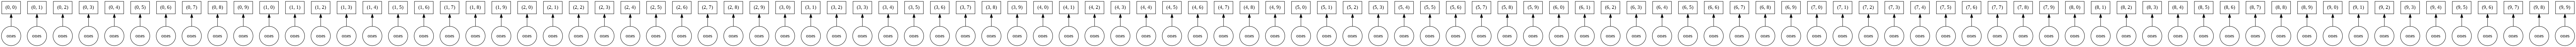

In [0]:
ones.visualize()

Our array has four chunks. To generate it, dask calls `np.ones` four times and then concatenates this together into one array.

Rather than immediately loading a dask array (which puts all the data into RAM), it is more common to reduce the data somehow. For example:

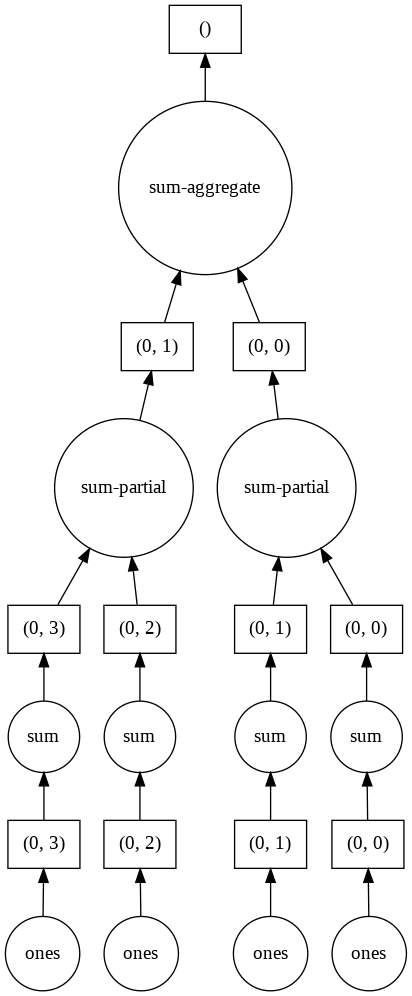

In [0]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Here we see dask's strategy for finding the sum. This simple example illustrates the beauty of dask: it automatically designs an algorithm appropriate for custom operations with big data. 

If we make our operation more complex, the graph gets more complex.

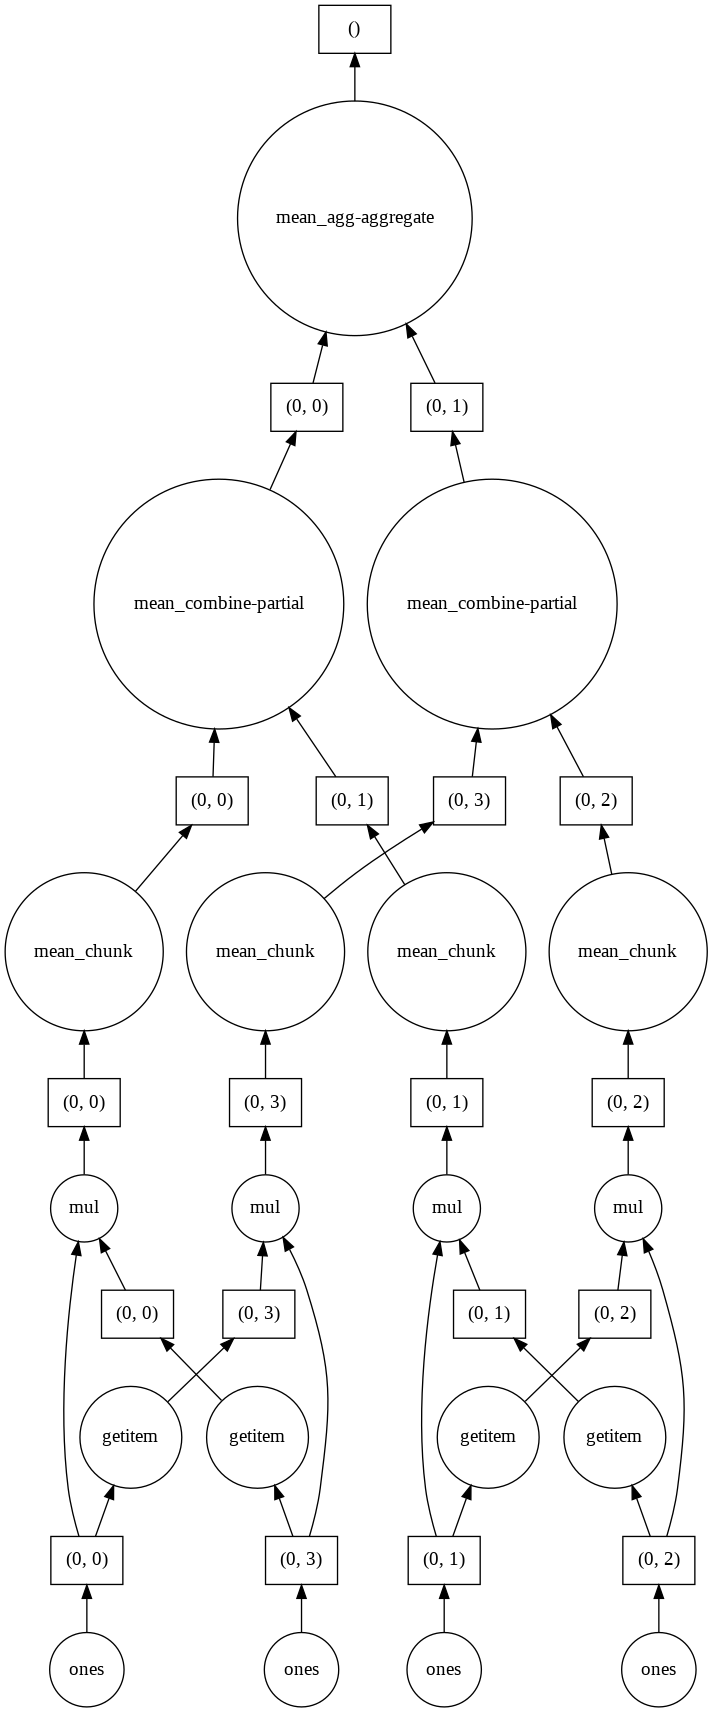

In [0]:
fancy_calculation = (ones * ones[::-1, ::-1]).mean()
fancy_calculation.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (32 MB) is nowhere nearly big enough to warrant the use of dask.

We can make it a lot bigger!

In [0]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000)>

In [0]:
print('%.1f MB' % (big_ones.nbytes / 1e6))

6400.0 MB


This dataset is 6.4 GB, rather than 32 MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, dask has no problem working on it.

_Do not try to `.visualize()` this array!_

When doing a big calculation, dask also has some tools to help us understand what is happening under the hood. Let's watch the dashboard again as we do a bigger computation.

In [0]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

result = big_calc.compute()
result

1.0

### Reduction 

All the usual numpy methods work on dask arrays.
You can also apply numpy function directly to a dask array, and it will stay lazy.

In [0]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=1)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(200000,), dtype=float64, chunksize=(1000,)>

Plotting also triggers computation, since we need the actual values

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

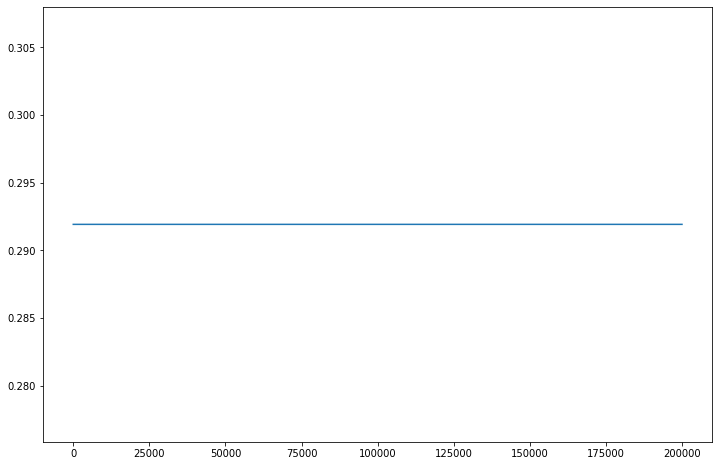

In [0]:
plt.plot(big_ones_reduce)

# Dask Delayed

Dask.delayed is a simple and powerful way to parallelize existing code.  It allows users to delay function calls into a task graph with dependencies.  Dask.delayed doesn't provide any fancy parallel algorithms like Dask.dataframe, but it does give the user complete control over what they want to build.

Systems like Dask.dataframe are built with Dask.delayed.  If you have a problem that is paralellizable, but isn't as simple as just a big array or a big dataframe, then dask.delayed may be the right choice for you.

## Create simple functions

These functions do simple operations like add two numbers together, but they sleep for a random amount of time to simulate real work.

In [0]:
import time

def inc(x):
    time.sleep(0.1)
    return x + 1

def dec(x):
    time.sleep(0.1)
    return x - 1
    
def add(x, y):
    time.sleep(0.2)
    return x + y 

We can run them like normal Python functions below

In [0]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 15.5 ms, sys: 1.15 ms, total: 16.6 ms
Wall time: 401 ms


These ran one after the other, in sequence.  Note though that the first two lines `inc(1)` and `dec(2)` don't depend on each other, we *could* have called them in parallel had we been clever.

## Annotate functions with Dask Delayed to make them lazy

We can call `dask.delayed` on our funtions to make them lazy.  Rather than compute their results immediately, they record what we want to compute as a task into a graph that we'll run later on parallel hardware.

In [0]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

Calling these lazy functions is now almost free.  We're just constructing a graph

In [0]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

CPU times: user 1.04 ms, sys: 2 µs, total: 1.04 ms
Wall time: 834 µs


## Visualize computation

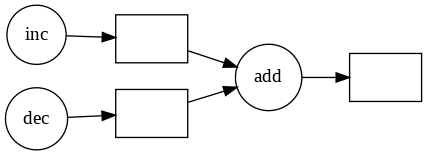

In [0]:
z.visualize(rankdir='LR')

## Run in parallel

Call `.compute()` when you want your result as a normal Python object

If you started `Client()` above then you may want to watch the status page during computation.

In [0]:
%%time
z.compute()

CPU times: user 18.9 ms, sys: 6.81 ms, total: 25.7 ms
Wall time: 322 ms


3

## Parallelize Normal Python code

Now we use Dask in normal for-loopy Python code.  This generates graphs instead of doing computations directly, but still looks like the code we had before.  Dask is a convenient way to add parallelism to existing workflows.

In [0]:
%%time
zs = []
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)
    
zs = dask.persist(*zs)  # trigger computation in the background

CPU times: user 223 ms, sys: 18.2 ms, total: 241 ms
Wall time: 238 ms


To make this go faster, add additional workers.

In [0]:
#cluster.scale(8)
#cluster

# Dask Deploy

The Dask library is written in pure Python. Installation of Dask is as simple as:

```shell
$ pip install "dask[complete]"
# or
$ conda install dask
```


Once dask is installed, the steps to deploying dask differ depending on the the computational infrastructure you are working with and what scheduler you plan to use. We'll briefly cover that topic next.

Dask-deploy docs: http://docs.dask.org/en/latest/setup.html

## Dask Schedulers

The Dask *Schedulers* orchestrate the tasks in the Task Graphs so that they can be run in parallel.  *How* they run in parallel, though, is determined by which *Scheduler* you choose.

There are 3 *local* schedulers:

- **Single-Thread Local:** For debugging, profiling, and diagnosing issues
- **Multi-threaded:** Using the Python built-in `threading` package (the default for all Dask operations except `Bags`)
- **Multi-process:** Using the Python built-in `multiprocessing` package (the default for Dask `Bags`)

and 1 *distributed* scheduler, which we will talk about later:

- **Distributed:** Using the `dask.distributed` module (which uses `tornado` for TCP communication). The distributed scheduler uses a `Cluster` to manage communication between the scheduler and the "workers". This is described in the next section.

## Distributed Clusters (http://distributed.dask.org/)

Dask can be deployed on distributed infrastructure, such as a an HPC system or a cloud computing system.

- `LocalCluster` - Creates a `Cluster` that can be executed locally. Each `Cluster` includes a `Scheduler` and `Worker`s. 
- `Client` - Connects to and drives computation on a distributed `Cluster`

### Dask Jobqueue (http://jobqueue.dask.org/)

- `PBSCluster`
- `SlurmCluster`
- `LSFCluster`
- etc.

### Dask Kubernetes (http://kubernetes.dask.org/)

- `KubeCluster`
